In [13]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob 
import segmenteverygrain as seg
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [14]:
from importlib import reload
reload(seg)

<module 'segmenteverygrain' from 'c:\\Users\\Jeffrey.Roth.NMES\\projects\\stranger-sections\\.venv\\Lib\\site-packages\\segmenteverygrain\\__init__.py'>

## Create patches from large images

In [16]:
image_dir = 'Tiles/images/'
mask_dir = 'Tiles/labels/'
dirname = 'images/output/'
images = sorted(glob(dirname + "*image*"))
labels = sorted(glob(dirname + "*mask*"))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = image_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]
    
start_no = 0
for image in tqdm(labels):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = large_image[:,:,0,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname = mask_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]

100%|██████████| 3/3 [00:00<00:00, 28.70it/s]


## Create training, validation, and test sets

In [17]:
breakimage_dir = 'Tiles/images/'
mask_dir = 'Tiles/labels/'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

batch_size = 32
shuffle_buffer_size = 1000

# split half into training
train_idx = np.random.choice(np.arange(len(image_files)), size = int(len(image_files)/2) , replace=False)
# get the rest
idx = np.setdiff1d(np.arange(len(image_files)), train_idx)
# get val files (25% of total)
val_idx = np.random.choice(idx, size = int(len(image_files)/4) , replace=False)
# get test files (25% of total)
test_idx = np.setdiff1d(val_idx, train_idx)

# create arrays of training, validation, and test files (these are filenames)
train_images = np.array(image_files)[train_idx]
val_images = np.array(image_files)[val_idx]
test_images = np.array(image_files)[test_idx]

train_masks = np.array(mask_files)[train_idx]
val_masks = np.array(mask_files)[val_idx]
test_masks = np.array(mask_files)[test_idx]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
breakimage_dir = 'Tiles/images/'
mask_dir = 'Tiles/labels/'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

batch_size = 32
shuffle_buffer_size = 1000

In [19]:
# split half into training
train_idx = np.random.choice(np.arange(len(image_files)), size = int(len(image_files)/2) , replace=False)
print(train_idx)
# get the rest
idx = np.setdiff1d(np.arange(len(image_files)), train_idx)
# get val files (25% of total)
val_idx = np.random.choice(idx, size = int(len(image_files)/4) , replace=False)
# get test files (25% of total)
test_idx = np.setdiff1d(val_idx, train_idx)

[35 39 59 36  7 44 21  6  5 28 20 22 19 58 10  0 11 30  3 57 49  4 23 51
 18 46 37 15 17 29]


In [20]:
# create arrays of training, validation, and test files (these are filenames)
train_images = np.array(image_files)[train_idx]
val_images = np.array(image_files)[val_idx]
test_images = np.array(image_files)[test_idx]

train_masks = np.array(mask_files)[train_idx]
val_masks = np.array(mask_files)[val_idx]
test_masks = np.array(mask_files)[test_idx]

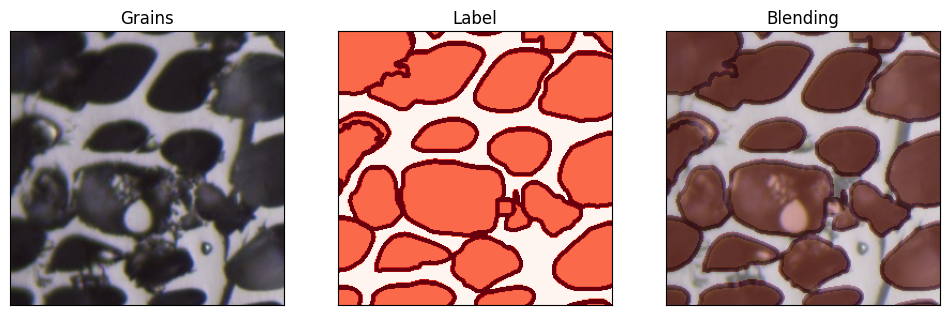

In [23]:
# check how masks look like
fname = train_images[25]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # need to convert from BGR to RGB
mask = cv2.imread(fname.replace('images', 'labels'))
seg.plot_images_and_labels(img, mask)

## Build, train, and evaluate model

In [24]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [30]:
history = model.fit(train_dataset, epochs=200, validation_data=val_dataset)

Epoch 1/200


1/1 [==============================] - 4s 4s/step - loss: 0.6584 - accuracy: 0.9956 - val_loss: 1.2014 - val_accuracy: 0.6655
Epoch 2/200
1/1 [==============================] - 4s 4s/step - loss: 0.6583 - accuracy: 0.9958 - val_loss: 1.2014 - val_accuracy: 0.6655
Epoch 3/200
1/1 [==============================] - 4s 4s/step - loss: 0.6582 - accuracy: 0.9958 - val_loss: 1.2014 - val_accuracy: 0.6655
Epoch 4/200
1/1 [==============================] - 4s 4s/step - loss: 0.6580 - accuracy: 0.9959 - val_loss: 1.2014 - val_accuracy: 0.6655
Epoch 5/200
1/1 [==============================] - 4s 4s/step - loss: 0.6579 - accuracy: 0.9960 - val_loss: 1.2014 - val_accuracy: 0.6655
Epoch 6/200
1/1 [==============================] - 4s 4s/step - loss: 0.6578 - accuracy: 0.9962 - val_loss: 1.2014 - val_accuracy: 0.6655
Epoch 7/200
1/1 [==============================] - 4s 4s/step - loss: 0.6577 - accuracy: 0.9964 - val_loss: 1.2014 - val_accuracy: 0.6655
Epoch 8/200
1/1 [=============================

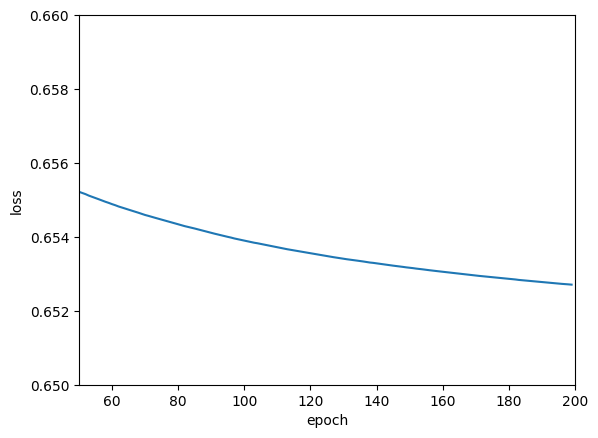

In [40]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss');
plt.xlim([50,200])
plt.ylim([0.65, 0.66]);

(0.66, 1.0)

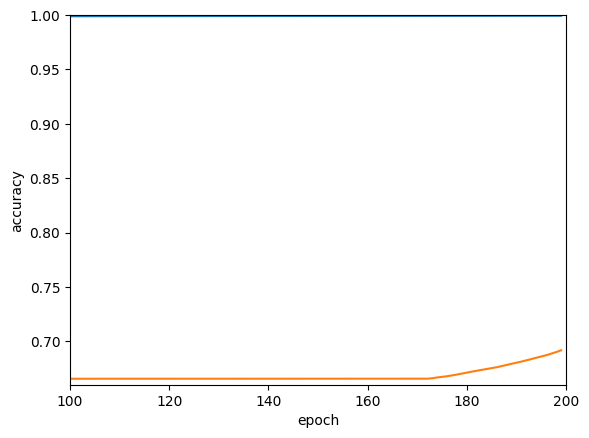

In [44]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([100,200])
plt.ylim([0.66, 1.0])

In [33]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 434ms/step - loss: 1.1739 - accuracy: 0.6916


[1.1738916635513306, 0.6916443109512329]

In [46]:
model.save_weights('checkpoints/seg_model_examples')